#Task 1;

In [1]:
!pip install filterpy

import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, sqrt
from filterpy.stats import plot_covariance_ellipse

    100% |████████████████████████████████| 184kB 26.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy


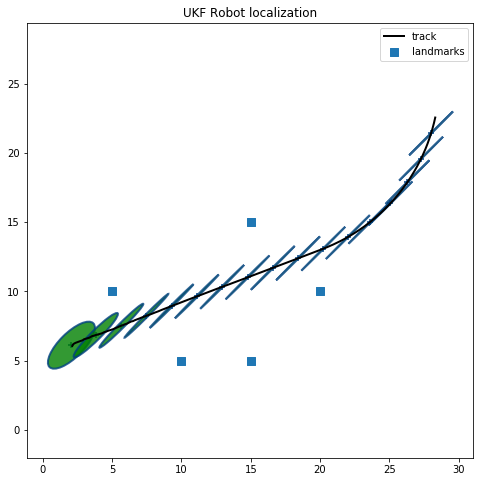

In [81]:
def predict_x(u, x, b):
    sr = u[1] * delta_t
    sl = u[0] * delta_t
    x[0] = x[0] + 0.5*(sr + sl) * cos( x[2] + 0.5 * (sr-sl)/b)
    x[1] = x[1] + 0.5 * (sr + sl) * sin(x[2] + 0.5 * (sr - sl) / b)
    x[2] = normalize_angle(x[2] +  (sr - sl)  / b)
    return x

def normalize_angle(theta):
    theta = theta % (2 *np.pi)
    if theta > np.pi:
        theta -= 2*np.pi
    return theta

def residual_h(z, ze):
    y = z -ze
    for i in range (0, len(y), 2):
        y[i+1]= normalize_angle(y[i+1])
    return y

def h(x, landmarks):
    hx = []
    for landmark in landmarks:
        px, py = landmark
        dist = sqrt((px - x[0])**2 + (py - x[1])**2)
        angle = np.arctan2(py - x[1], px - x[0])
        hx.append(dist)
        hx.append( normalize_angle(angle - x[2]) )
    return np.array(hx)

def predict_P( P, Q, Phi):
    P = np.dot(Phi, np.dot( P, Phi.transpose()) ) + Q
    return P

def update_P(P, K, H):
    return P - np.dot(K, np.dot(H, P))

def calcul_K(P, H, R):
    cov_v = np.dot( H, np.dot(P, H.transpose()) ) + R
    return np.dot( np.dot(P, H.transpose()),  np.linalg.inv(cov_v) )



def EKF_robot(landmarks, b, sigma_r, sigma_phi, cmds, ellipse_step = 5):
  x = np.array([2, 6, .44])
  for landmark in landmarks:
    x = np.append(x, landmark)
    
  P  = np.zeros((x.shape[0], x.shape[0]))
  P[:3, :3] = np.diag([.2, .2, .05])
  P[3:, 3:] = np.eye(landmarks.shape[0]*2)*1000
  
  R = np.diag([sigma_r ** 2, sigma_phi ** 2] * len(landmarks))
  Q = np.eye(x.shape[0]) * 0.0001   

  plt.figure(figsize=(8,8))
  if len(landmarks) > 0:
      plt.scatter(landmarks[:, 0], landmarks[:, 1], marker='s', s=60, label = 'landmarks')

  path =[]
  for i, u in enumerate(cmds):
    x = predict_x(u, x, b)

    path.append(np.array(x))
    sr = u[1] * delta_t
    sl = u[0] * delta_t
    
    Phi = np.eye(x.shape[0])
    Phi[:3, :3] = np.array([[1, 0, - 0.5 * (sr + sl) * sin(x[2] + 0.5 * (sr - sl))],
                    [0, 1, 0.5 * (sr + sl) * cos(x[2] + 0.5 * (sr - sl))], [0, 0, 1]])
    j=0
    H = np.zeros( [2* landmarks.shape[0], x.shape[0]] )
    for k, landmark in enumerate(landmarks):
        px, py = landmark
        H[j, :3] = [(-px + x[0]) / (sqrt((px - x[0]) ** 2 + (py - x[1]) ** 2)),
               (-py + x[1]) / (sqrt((px - x[0]) ** 2 + (py - x[1]) ** 2)), 0]
        H[j, 3+k:3+k+2] = [(px - x[0]) / (sqrt((px - x[0]) ** 2 + (py - x[1]) ** 2)),  (py - x[1]) / (sqrt((px - x[0]) ** 2 + (py - x[1]) ** 2))]
        
        H[j+1, :3] = [(py - x[1]) / (sqrt((px - x[0]) ** 2 + (py - x[1]) ** 2)),
               (-px + x[0]) / (sqrt((px - x[0]) ** 2 + (py - x[1]) ** 2)), -1]
        H[j+1, 3+k:3+k+2] = [(-py + x[1]) / (sqrt((px - x[0]) ** 2 + (py - x[1]) ** 2)),  (px - x[0]) / (sqrt((px - x[0]) ** 2 + (py - x[1]) ** 2))]
        j +=2

    ###  generate data from sensor
    z = []
    for landmark in landmarks:
        dx, dy = landmark[0] - x[0], landmark[1] - x[1]
        d = sqrt(dx**2 + dy**2) + np.random.randn()*sigma_r
        bearing = np.arctan2(dy, dx)
        a = normalize_angle(bearing - x[2] + np.random.randn()*sigma_phi)
        z.append(d)
        z.append(a)

    z = np.array(z)
    P_ = predict_P( P, Q, Phi)
    ze  = h(x, landmarks)
    v= residual_h(z, ze)
    K = calcul_K(P, H, R)

    x = x + np.dot(K, v)
    P = update_P(P, K, H)
    if i % ellipse_step == 0:
      plot_covariance_ellipse((x[0], x[1]), P[0:2, 0:2], std=5,
            facecolor='g', alpha=0.8)
        
  return np.array(path)

delta_t  = 0.1
b= 0.2
landmarks = np.array([[5, 10], [10, 5], [15,5],  [15, 15],  [20, 10]])
cmds = [np.array([1.3, 1.3])] * 150
cmds  = cmds + [np.array([1.30, 1.32])] * 100
# print(cmds)
sigma_r = 0.3
sigma_phi = 0.1

track = EKF_robot(landmarks, b, sigma_r, sigma_phi, cmds, ellipse_step = 15)
plt.plot(track[:, 0], track[:,1], color='k', lw=2, label = 'track')
plt.axis('equal')
plt.title("UKF Robot localization")
plt.legend()
plt.show()


#Task 2 :

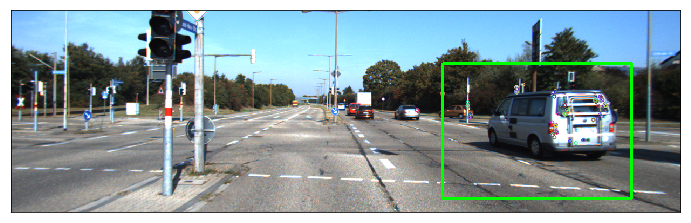

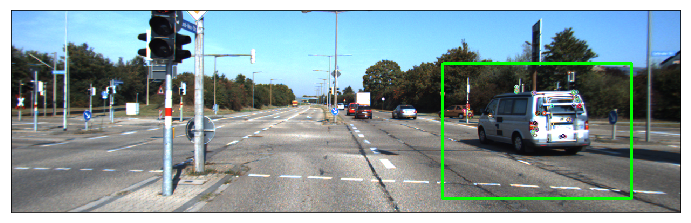

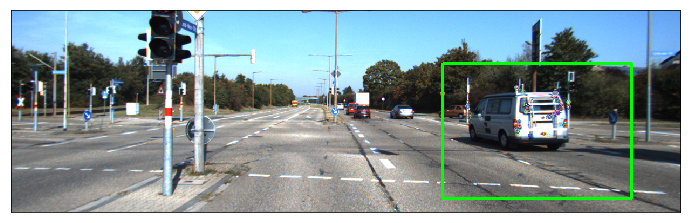

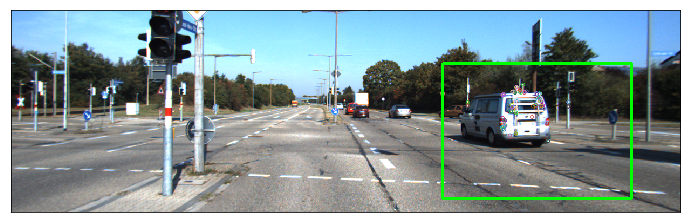

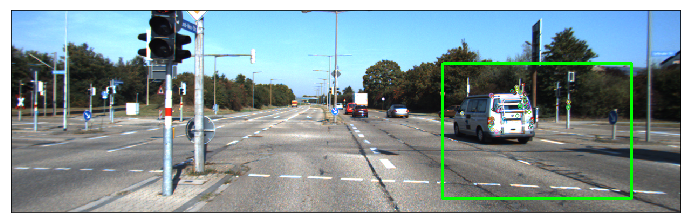

the number of keypoints for each image is :100


In [12]:
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt
import cv2
plt.rcParams["figure.figsize"] = (12, 7) # (w, h)

images = ['0000000130.png' , '0000000131.png', '0000000132.png', '0000000133.png', '0000000134.png']
imgs =[]
keypoints = []
for image in images: 
  img = cv2.imread(image, cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  imgs.append(img)
  cv2.rectangle(img,(800,100),(1150,350),(0,255,0),3)

  image_keypoints = img.copy()
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  mask = np.zeros(gray.shape, np.uint8)
  mask[100:350 , 750:1150] = 255
  orb = cv2.ORB_create(nfeatures= 100)
  # kp = orb.detect(gray,mask)
  kp, des=orb.detectAndCompute(gray,mask)
#   image_keypoints =cv2.drawKeypoints(image,kp,image_keypoints,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  image_keypoints =cv2.drawKeypoints(img,kp,image_keypoints,flags=0)
  keypoints.append([kp, des])
  
  plt.imshow(image_keypoints)
  plt.xticks([]),plt.yticks([])
  plt.show()

print('the number of keypoints for each image is :{}'.format(len(keypoints[1][0]))) 

In [0]:
plt.rcParams["figure.figsize"] = (20, 20) # (w, h)

def draw_matches(imgs,  keypoints, ind1, ind2, match_idx, use_oneKeypoint, idx_keypoint1=0):
  if use_oneKeypoint:
    kpsA = keypoints[ind1][0][idx_keypoint1:idx_keypoint1 + 1]
    featuresA = keypoints[ind1][1][idx_keypoint1 : idx_keypoint1 + 1]
  else:
    kpsA = keypoints[ind1][0]
    featuresA = keypoints[ind1][1]
    
  kpsB = keypoints[ind2][0]
  featuresB = keypoints[ind2][1]
  imageA = imgs[ind1]
  imageB= imgs[ind2]
  
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  matches = bf.match(featuresA,featuresB)
  # Sort the matches in the order of their distance.
  matches = sorted(matches, key = lambda x:x.distance)
  H =np.identity(3)
  result = cv2.warpPerspective(imageA, H,(imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
  result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

  # Draw the matches.
  result = cv2.drawMatches(imageA,kpsA,imageB,kpsB,matches[match_idx:match_idx+1],result, flags=2)
  
  imgIdx, trainIdx , queryIdx = matches[match_idx].imgIdx, matches[match_idx].trainIdx , matches[match_idx].queryIdx
  print(imgIdx)
  cv2.circle(result,(int(kpsA[queryIdx].pt[0]), int(kpsA[queryIdx].pt[1])), 10, (0,0,255), -1)
  cv2.circle(result,(int(kpsB[trainIdx].pt[0])+imageA.shape[1], int(kpsB[trainIdx].pt[1])), 10, (0,0,255), -1)
#   result =cv2.drawKeypoints(img,kp,image_keypoints,flags=0)

  plt.imshow(result),plt.show()
  return imgIdx, trainIdx , queryIdx

0


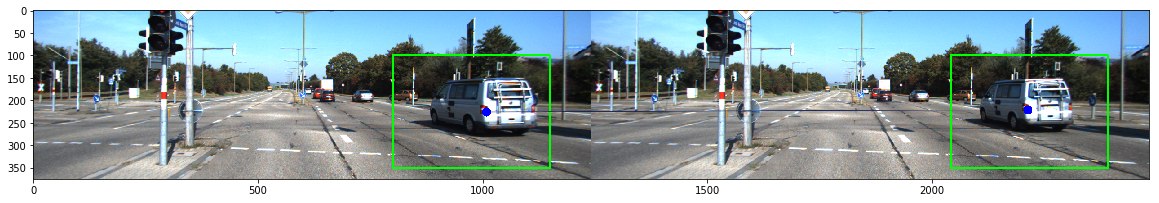

the matched keypoint in the first image is located at :(1009.8433227539062, 226.02243041992188)
the matched keypoint in the second image is located at :(972.8640747070312, 221.18402099609375)


In [14]:
################### mathcing keypoints in the first image ######################
robot_pose =[]
ind1, ind2, match_idx = 0, 1, 7
use_oneKeypoint = 0
imgIdx, trainIdx , queryIdx= draw_matches(imgs,  keypoints, ind1, ind2, match_idx, use_oneKeypoint)
x1, y1 = keypoints[ind1][0][queryIdx].pt[0], keypoints[ind1][0][queryIdx].pt[1]
x2, y2= keypoints[ind2][0][trainIdx].pt[0], keypoints[ind2][0][trainIdx].pt[1]
robot_pose.append([x1, y1])
print('the matched keypoint in the first image is located at :({}, {})'.format(x1, y1))
print('the matched keypoint in the second image is located at :({}, {})'.format(x2, y2))
robot_pose.append([x2, y2])

0


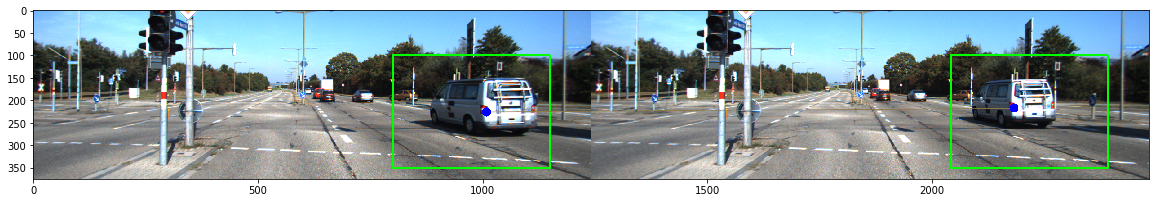

the matched keypoint in the first image is located at :(1009.8433227539062, 226.02243041992188)
the matched keypoint in the second image is located at :(941.7600708007812, 217.72802734375)


In [15]:
################### mathcing keypoints in the second image #####################
ind1, ind2, match_idx = 0, 2, 0
use_oneKeypoint = 1
idx_keypoint1 = queryIdx
imgIdx, trainIdx , queryIdx_2= draw_matches(imgs,  keypoints, ind1, ind2, match_idx, use_oneKeypoint, idx_keypoint1)
x1, y1 = keypoints[ind1][0][queryIdx].pt[0], keypoints[ind1][0][queryIdx].pt[1]
x2, y2= keypoints[ind2][0][trainIdx].pt[0], keypoints[ind2][0][trainIdx].pt[1]
print('the matched keypoint in the first image is located at :({}, {})'.format(x1, y1))
print('the matched keypoint in the second image is located at :({}, {})'.format(x2, y2))
robot_pose.append([x2, y2])

0


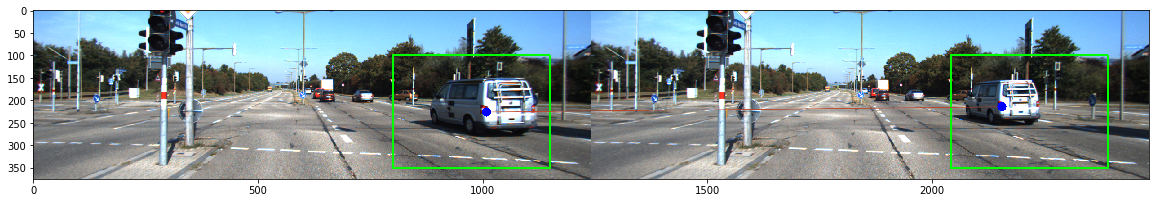

the matched keypoint in the first image is located at :(1009.8433227539062, 226.02243041992188)
the matched keypoint in the second image is located at :(914.4000244140625, 214.5600128173828)


In [0]:
################### mathcing keypoints in the third image ######################
ind1, ind2, match_idx = 0, 3, 0
use_oneKeypoint = 1
idx_keypoint1 = queryIdx
imgIdx, trainIdx , queryIdx_2= draw_matches(imgs,  keypoints, ind1, ind2, match_idx, use_oneKeypoint, idx_keypoint1)
x1, y1 = keypoints[ind1][0][queryIdx].pt[0], keypoints[ind1][0][queryIdx].pt[1]
x2, y2= keypoints[ind2][0][trainIdx].pt[0], keypoints[ind2][0][trainIdx].pt[1]
print('the matched keypoint in the first image is located at :({}, {})'.format(x1, y1))
print('the matched keypoint in the second image is located at :({}, {})'.format(x2, y2))
robot_pose.append([x2, y2])

0


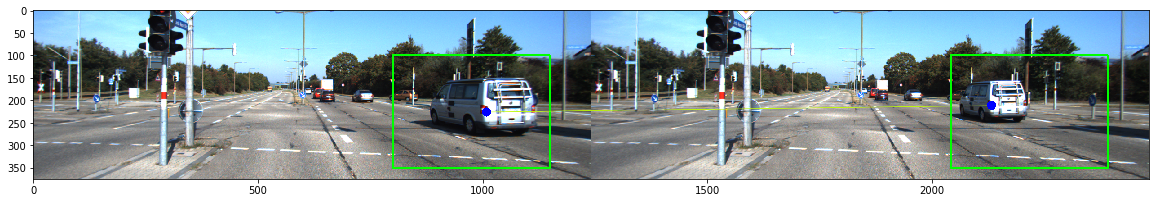

the matched keypoint in the first image is located at :(1009.8433227539062, 226.02243041992188)
the matched keypoint in the second image is located at :(891.3600463867188, 211.6800079345703)


In [16]:
################### mathcing keypoints in the fourth image #####################
ind1, ind2, match_idx = 0, 4, 0
use_oneKeypoint = 1
idx_keypoint1 = queryIdx
imgIdx, trainIdx , queryIdx_2= draw_matches(imgs,  keypoints, ind1, ind2, match_idx, use_oneKeypoint, idx_keypoint1)
x1, y1 = keypoints[ind1][0][queryIdx].pt[0], keypoints[ind1][0][queryIdx].pt[1]
x2, y2= keypoints[ind2][0][trainIdx].pt[0], keypoints[ind2][0][trainIdx].pt[1]
print('the matched keypoint in the first image is located at :({}, {})'.format(x1, y1))
print('the matched keypoint in the second image is located at :({}, {})'.format(x2, y2))
robot_pose.append([x2, y2])

In [17]:
robot_pose = np.array(robot_pose)
print(robot_pose)

[[1009.84332275  226.02243042]
 [ 972.86407471  221.184021  ]
 [ 941.7600708   217.72802734]
 [ 891.36004639  211.68000793]]


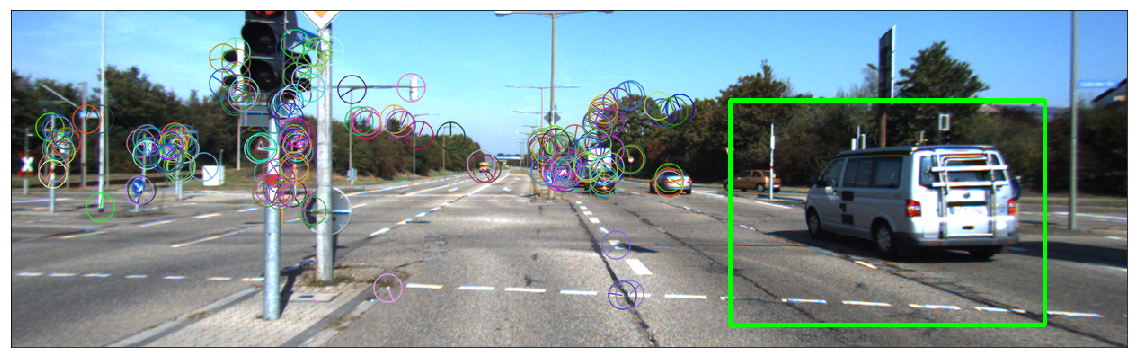

In [82]:
img = imgs[0]
image_keypoint = img.copy()
cv2.rectangle(image_keypoint,(800,100),(1150,350),(0,255,0),3)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.ones(gray.shape, np.uint8)
mask[: , int(mask.shape[1]*0.6): mask.shape[1]] = 0
orb = cv2.ORB_create(nfeatures= 800)
kps, des=orb.detectAndCompute(gray,mask)
# image_keypoints =cv2.drawKeypoints(img,kps,image_keypoints,flags=0)
image_keypoint =cv2.drawKeypoints(img,kps,image_keypoint,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(image_keypoint)
plt.xticks([]),plt.yticks([])
plt.show()

In [83]:
nb_landmarks =5
landmarks = []
for i in range (nb_landmarks):
  landmarks.append([kps[i].pt[0], kps[i].pt[1]]) 
landmarks = np.array(landmarks)
print(landmarks)

[[645. 175.]
 [180. 153.]
 [592. 153.]
 [617. 186.]
 [652. 125.]]


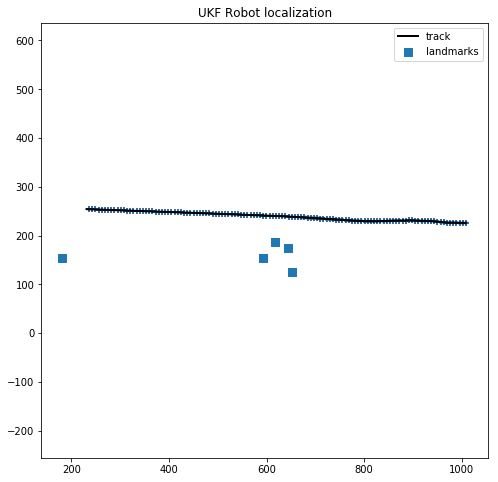

In [85]:
def EKF_robot_CV(landmarks, b, sigma_r, sigma_phi, cmds, x_ini, ellipse_step = 5):
  x = x_ini
  for landmark in landmarks:
    x = np.append(x, landmark)
    
  P  = np.zeros((x.shape[0], x.shape[0]))
  P[:3, :3] = np.diag([.2, .2, .05])
  P[3:, 3:] = np.eye(landmarks.shape[0]*2)
  
  R = np.diag([sigma_r ** 2, sigma_phi ** 2] * len(landmarks))
  Q = np.eye(x.shape[0]) * 0.0001   

  plt.figure(figsize=(8,8))
  if len(landmarks) > 0:
      plt.scatter(landmarks[:, 0], landmarks[:, 1], marker='s', s=60, label = 'landmarks')

  path =[]
  for i, u in enumerate(cmds):
    x = predict_x(u, x, b)

    path.append(np.array(x))
    sr = u[1] * delta_t
    sl = u[0] * delta_t
    
    Phi = np.eye(x.shape[0])
    Phi[:3, :3] = np.array([[1, 0, - 0.5 * (sr + sl) * sin(x[2] + 0.5 * (sr - sl))],
                    [0, 1, 0.5 * (sr + sl) * cos(x[2] + 0.5 * (sr - sl))], [0, 0, 1]])
    j=0
    H = np.zeros( [2* landmarks.shape[0], x.shape[0]] )
    for k, landmark in enumerate(landmarks):
        px, py = landmark
        H[j, :3] = [(-px + x[0]) / (sqrt((px - x[0]) ** 2 + (py - x[1]) ** 2)),
               (-py + x[1]) / (sqrt((px - x[0]) ** 2 + (py - x[1]) ** 2)), 0]
        H[j, 3+k:3+k+2] = [(px - x[0]) / (sqrt((px - x[0]) ** 2 + (py - x[1]) ** 2)),  (py - x[1]) / (sqrt((px - x[0]) ** 2 + (py - x[1]) ** 2))]
        
        H[j+1, :3] = [(py - x[1]) / (sqrt((px - x[0]) ** 2 + (py - x[1]) ** 2)),
               (-px + x[0]) / (sqrt((px - x[0]) ** 2 + (py - x[1]) ** 2)), -1]
        H[j+1, 3+k:3+k+2] = [(-py + x[1]) / (sqrt((px - x[0]) ** 2 + (py - x[1]) ** 2)),  (px - x[0]) / (sqrt((px - x[0]) ** 2 + (py - x[1]) ** 2))]
        j +=2

    ###  generate data from sensor
    z = []
    for landmark in landmarks:
        dx, dy = landmark[0] - x[0], landmark[1] - x[1]
        d = sqrt(dx**2 + dy**2) + np.random.randn()*sigma_r
        bearing = np.arctan2(dy, dx)
        a = normalize_angle(bearing - x[2] + np.random.randn()*sigma_phi)
        z.append(d)
        z.append(a)

    z = np.array(z)
    P_ = predict_P( P, Q, Phi)
    ze  = h(x, landmarks)
    v= residual_h(z, ze)
    K = calcul_K(P, H, R)

    x = x + np.dot(K, v)
    P = update_P(P, K, H)

    if i % ellipse_step == 0:
        plot_covariance_ellipse((x[0], x[1]), P[0:2, 0:2], std=5,
            facecolor='g', alpha=0.8)
  return np.array(path)

delta_t  = 1
b= 0.2
cmds = [np.array([1.3, 1.3])] * 600
sigma_r = 0.3
sigma_phi = 0.1
x_ini = robot_pose[0, :]
x_ini = np.hstack((x_ini, 3.13))

track = EKF_robot_CV(landmarks, b, sigma_r, sigma_phi, cmds, x_ini)
plt.plot(track[:, 0], track[:,1], color='k', lw=2, label = 'track')
plt.axis('equal')
plt.title("UKF Robot localization")
plt.legend()
plt.show()
